# Iteración 1
Tras explorar en detenimiento los datos y tener claras la preguntas de negocio se procede a generar un modelo (regresivo)

## Librerías

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## Importación de datos limpios y breve exploración

In [2]:
# df = pd.read_csv("Repositorio-Proyecto1\Ingeniería y análisis de datos\data_limpia.csv")
df = pd.read_csv("data_limpia.csv")
df.head()

,category,bathrooms,bedrooms,has_photo,price,price_display,price_type,square_feet,cityname,state,latitude,longitude,time
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,790,Monthly,101,Washington,DC,389057.0,-769861.0,1577359415
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,425,Monthly,106,Evansville,IN,379680.0,-876621.0,1577017063
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,1.39,Monthly,107,Arlington,VA,388910.0,-770816.0,1577359410
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,925,Monthly,116,Seattle,WA,476160.0,-1223275.0,1576667743
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,880,Monthly,125,Arlington,VA,388738.0,-771055.0,1577359401


In [3]:
df.describe()

,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9917.000000,9917.000000,9917.000000,9917.000000,9917.000000,9.917000e+03,9.917000e+03
mean,1.379097,1.743471,1486.055864,945.903499,376834.312796,-9.462911e+05,1.574871e+09
std,0.615455,0.941908,1078.397223,657.251935,55105.576026,1.581312e+05,3.771848e+06
min,1.000000,0.000000,200.000000,101.000000,213155.000000,-1.580221e+06,1.568744e+09
25%,1.000000,1.000000,949.000000,649.000000,336683.000000,-1.018587e+06,1.568781e+09
50%,1.000000,2.000000,1270.000000,802.000000,387555.000000,-9.365160e+05,1.577358e+09
75%,2.000000,2.000000,1695.000000,1100.000000,413712.000000,-8.187790e+05,1.577359e+09
max,8.500000,9.000000,52500.000000,40000.000000,615940.000000,-7.019160e+05,1.577362e+09


## Visualización y correlación

In [4]:
Variables_Num = df.select_dtypes(include=['number']).columns.tolist()
Variables_NoNum = df.select_dtypes(exclude=['number']).columns.tolist()

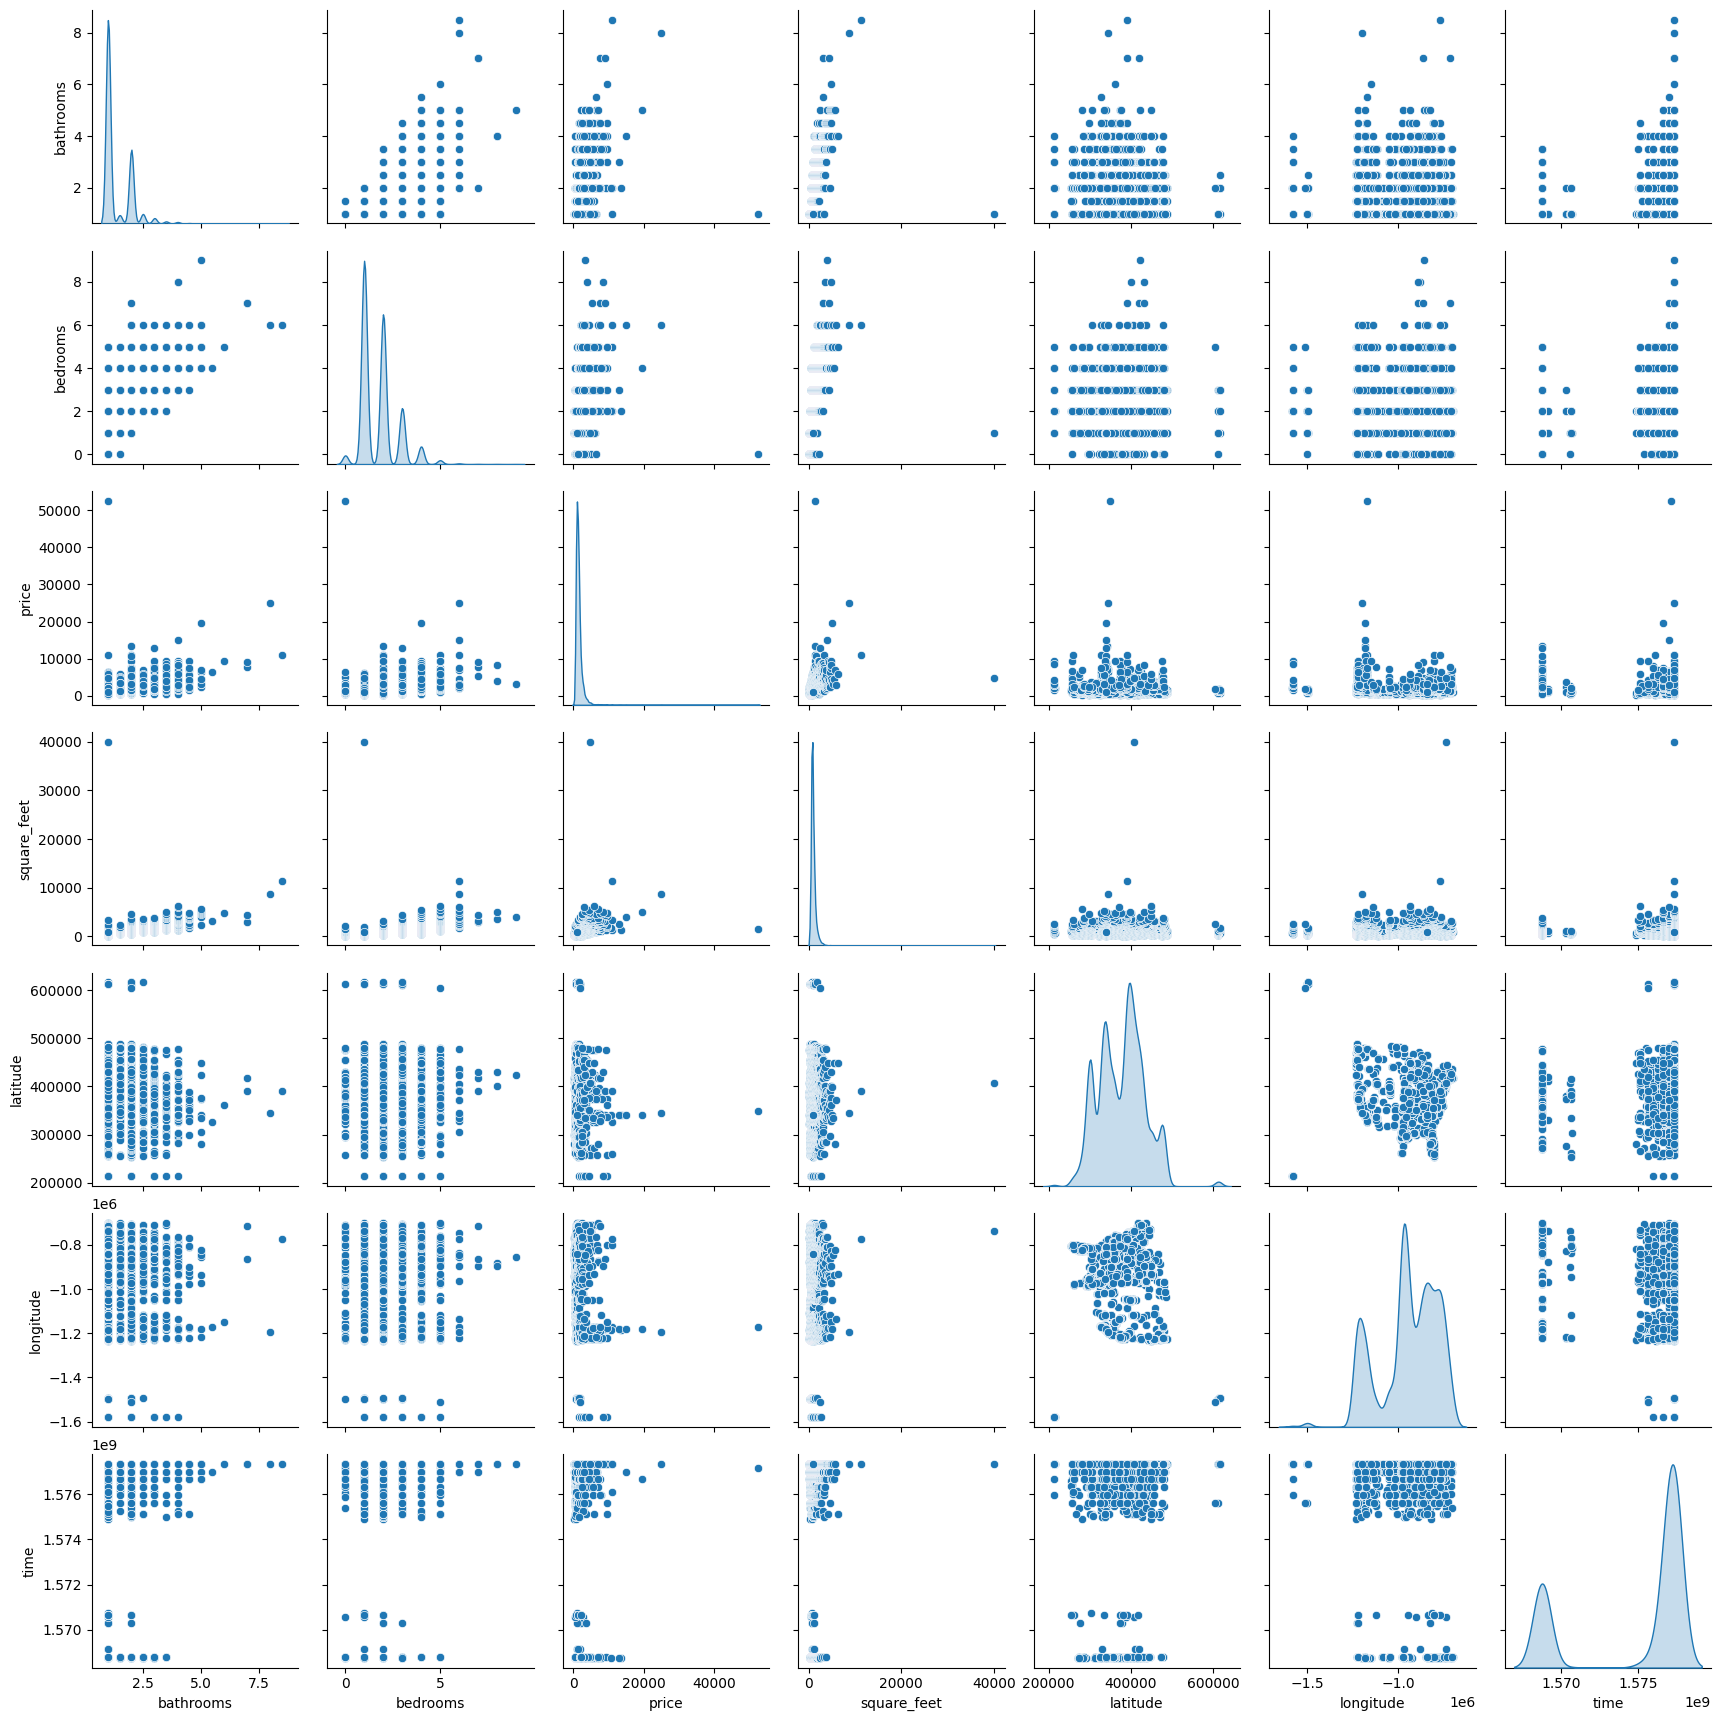

In [5]:
sns.pairplot(df, diag_kind="kde")

### Variables numéricas exclusivamente

<Axes: >

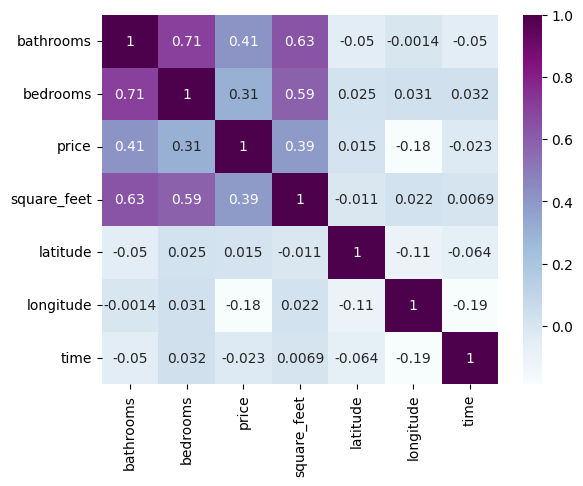

In [6]:
numeric_df = df.select_dtypes(include=['number']) 
sns.heatmap(numeric_df.corr(), cmap="BuPu", annot=True)

<Axes: >

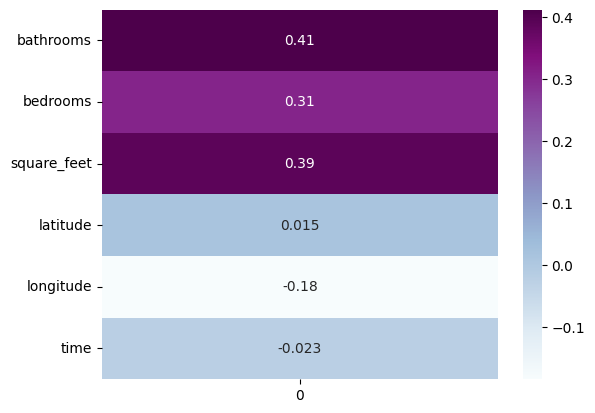

In [7]:
corr_price = numeric_df.drop(['price'], axis=1).corrwith(numeric_df['price'])
sns.heatmap(pd.DataFrame(corr_price), cmap="BuPu", annot=True)

La visualización de correlaciones con la variable de interés dan indicios como:
* _bathrooms_, _bedrooms_ y _squarefeet_ parecen ser las variables más indicadas para explicar el precio
* La influencia de _latitude_, _longitude_ y _time_ en principio parece no ser indispensable

In [8]:
Variables_Num.remove("time")
Variables_Num.remove("longitude")
Variables_Num.remove("latitude")

### Variables categóricas/no numéricas

In [9]:
def mi_boxplot_grid(df, categorical_columns, target_col="price", figsize=(15, 10), nrows=2, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle("Distribución del Precio según Variables Categóricas", fontsize=16, y=1.02)

    axes = axes.flatten()

    for i, col in enumerate(categorical_columns):
        sns.boxplot(x=col, y=target_col, data=df, ax=axes[i])
        axes[i].set_title(f"Precio según {col}")
        axes[i].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

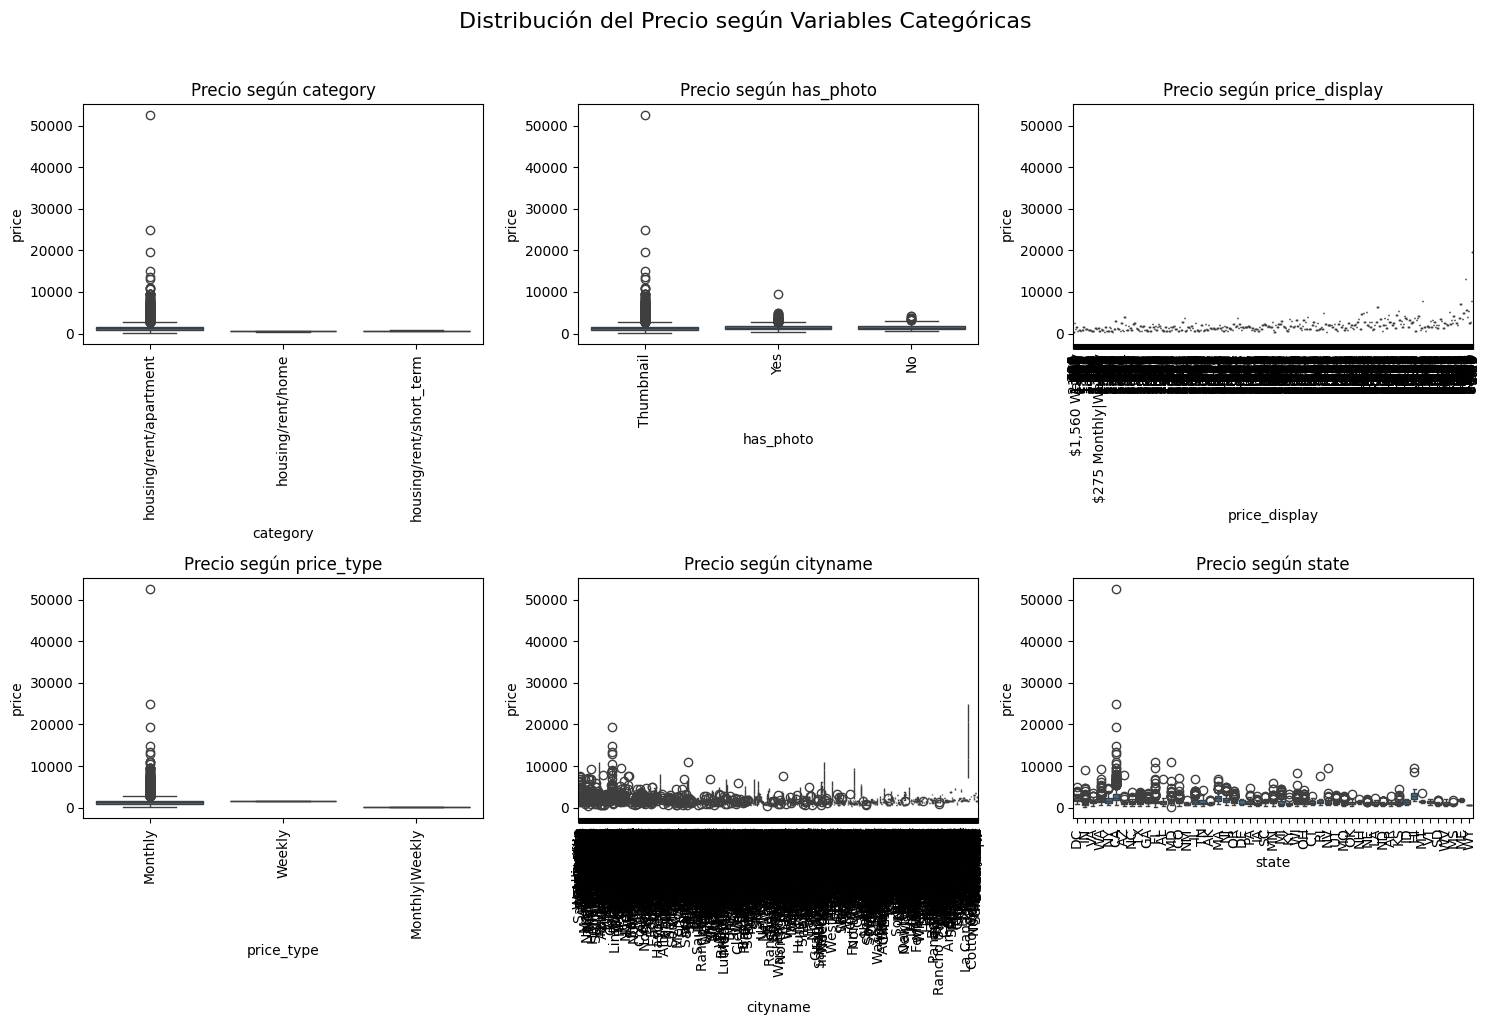

In [10]:
mi_boxplot_grid(df, Variables_NoNum, nrows=2, ncols=3)

Los Boxplots del preció según los valores de las variables categóricas dan indicios como:
* _State_ debería tener integrada la información de _Cityname_, al menos a groso modo
* _Pricedisplay_ apesar de haber sido identificada como no numérica por pandas parece contener información numérica continua
    * Revisando los datos, _Pricedisplay_ almacena el mismo precio pero con un formato distinto. Es decir, no es una variable relevante pues no integra más información que la del precio y en ocasiones la del _Pricetype_

In [11]:
Variables_NoNum.remove("price_display")
Variables_NoNum.remove("cityname")

## Modelo de regresión
Habiendo explorado los datos y comprendido las correlaciones se puede ahora realizar aproximaciones al modelo

In [12]:
Variables_explicativas = Variables_NoNum + Variables_Num
#Variables_explicativas.remove("price")
print(Variables_explicativas)

['category', 'has_photo', 'price_type', 'state', 'bathrooms', 'bedrooms', 'price', 'square_feet']


La primer propuesta de modelo sería: 

$y = \beta_0 + \beta_1 \times \text{bathrooms} + \beta_2 \times \text{bedrooms} + \beta_3 \times \text{square\_feet} + \beta_4 \times \text{category} + \beta_5 \times \text{has\_photo} + \beta_6 \times \text{price\_type} + \beta_7 \times \text{state}$

Como varias variables no numéricas elegidas para el modelo son categóricas, para poder integrarlas se hace necesario el uso de dummies

In [13]:
df_modelo = df[Variables_explicativas]
df_modelo = pd.get_dummies(df_modelo, columns=Variables_NoNum, drop_first=True)
df_modelo.head()


,bathrooms,bedrooms,price,square_feet,category_housing/rent/home,category_housing/rent/short_term,has_photo_Thumbnail,has_photo_Yes,price_type_Monthly|Weekly,price_type_Weekly,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1.0,0.0,790,101,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.0,1.0,425,106,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.0,0.0,1390,107,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1.0,0.0,925,116,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,1.0,0.0,880,125,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [14]:
print((df_modelo.columns))

Index(['bathrooms', 'bedrooms', 'price', 'square_feet',
       'category_housing/rent/home', 'category_housing/rent/short_term',
       'has_photo_Thumbnail', 'has_photo_Yes', 'price_type_Monthly|Weekly',
       'price_type_Weekly', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA',
       'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS',
       'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI',
       'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND',
       'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
       'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
       'state_WA', 'state_WI', 'state_WV', 'state_WY'],
      dtype='object')


In [15]:
features = ['bathrooms', 'bedrooms', 'square_feet',
       'category_housing/rent/home', 'category_housing/rent/short_term',
       'has_photo_Thumbnail', 'has_photo_Yes', 'price_type_Monthly|Weekly',
       'price_type_Weekly', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA',
       'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS',
       'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI',
       'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND',
       'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
       'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
       'state_WA', 'state_WI', 'state_WV', 'state_WY']
X = df_modelo[features]
Y = df_modelo['price'] 

### Entrenamiento del modelo

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

print(f"Dimensiones X de entrenamiento {X_train.shape}\nDimensiones X de test {X_test.shape}\nDimensiones Y de entrenamiento {Y_train.shape}\nDimensiones Y de test {Y_test.shape}")

Dimensiones X de entrenamiento (7437, 59)
Dimensiones X de test (2480, 59)
Dimensiones Y de entrenamiento (7437,)
Dimensiones Y de test (2480,)


In [17]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, Y_train)

Y_pred = linreg.predict(X_test)

print(f"Intercepto: {linreg.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(features, linreg.coef_):
    print(f"  {feature}: {coef:.4f}")

Intercepto: 236.9343
Coeficientes:
  bathrooms: 203.7656
  bedrooms: -90.2765
  square_feet: 0.9260
  category_housing/rent/home: -270.5596
  category_housing/rent/short_term: -682.4264
  has_photo_Thumbnail: 11.7580
  has_photo_Yes: -61.9625
  price_type_Monthly|Weekly: -442.6492
  price_type_Weekly: 1260.1214
  state_AL: -368.3062
  state_AR: -550.2220
  state_AZ: -42.8487
  state_CA: 1567.2822
  state_CO: 246.7481
  state_CT: 229.2568
  state_DC: 1104.4602
  state_DE: -60.6959
  state_FL: 167.9547
  state_GA: -143.0448
  state_HI: 1615.8438
  state_IA: -248.8637
  state_ID: 108.5312
  state_IL: 322.8766
  state_IN: -85.4476
  state_KS: -306.8340
  state_KY: -225.1854
  state_LA: -269.7994
  state_MA: 1097.0400
  state_MD: 346.7327
  state_ME: 729.8604
  state_MI: 2.9833
  state_MN: 239.4362
  state_MO: -153.4131
  state_MS: -371.4600
  state_MT: -25.4565
  state_NC: -247.4959
  state_ND: -364.5313
  state_NE: -221.7172
  state_NH: 291.8638
  state_NJ: 792.7023
  state_NM: -14.3771
 

### Evaluación del modelo

**Error absoluto medio**: 

$$\text{MAE} = \frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Error cuadrado medio**: 
$$\text{MSE} = \frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Raíz del Error cuadrado medio**: 
$$\text{RMSE} = \sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [18]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(Y_test, Y_pred)
MSE = metrics.mean_squared_error(Y_test, Y_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Squared Error (MSE): {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
R2 = metrics.r2_score(Y_test, Y_pred)
print(f"Coeficiente de determinación (R2): {R2:.4f}")

Mean Absolute Error (MAE): 373.0750
Mean Squared Error (MSE): 786921.0288
Root Mean Squared Error (RMSE): 887.0857
Coeficiente de determinación (R2): 0.0246


In [19]:
X_train.dtypes

bathrooms                           float64
bedrooms                            float64
square_feet                           int64
category_housing/rent/home             bool
category_housing/rent/short_term       bool
has_photo_Thumbnail                    bool
has_photo_Yes                          bool
price_type_Monthly|Weekly              bool
price_type_Weekly                      bool
state_AL                               bool
state_AR                               bool
state_AZ                               bool
state_CA                               bool
state_CO                               bool
state_CT                               bool
state_DC                               bool
state_DE                               bool
state_FL                               bool
state_GA                               bool
state_HI                               bool
state_IA                               bool
state_ID                               bool
state_IL                        

# Iteración 2
Ante unos cambios de ingeniería y ciencia de datos, es necesario repetir unos pasos de exploración y visualización, pues los datos limpios cambiaron un poco

## Importación de datos y exploración

In [20]:
df_2 = pd.read_csv("data_limpia_2.csv")
df_2.head()

,category,bathrooms,bedrooms,has_photo,price,price_display,price_type,square_feet,cityname,latitude,longitude,time
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,790,Monthly,101,Washington,389057.0,-769861.0,1577359415
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,425,Monthly,106,Evansville,379680.0,-876621.0,1577017063
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,1.39,Monthly,107,Arlington,388910.0,-770816.0,1577359410
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,925,Monthly,116,Seattle,476160.0,-1223275.0,1576667743
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,880,Monthly,125,Arlington,388738.0,-771055.0,1577359401


El más reciente cambio de ingeniería y ciencia de datos elimina la columna states, lo que supone un cambio en el primer modelo propuesto. Considerando las métricas de error del primer modelo, conviene una segunda iteración para el modelo. 
Pero como aprendizaje de la anterior exploración se descartará de una vez la variable _price\_display_ pues esta no aporta información que no se tenga ya en _price_ y en _price\_type_

## Visualización y correlación

In [21]:
Variables_Num = df_2.select_dtypes(include=['number']).columns.tolist()
Variables_NoNum = df_2.select_dtypes(exclude=['number']).columns.tolist()
Variables_NoNum.remove("price_display")

<Axes: >

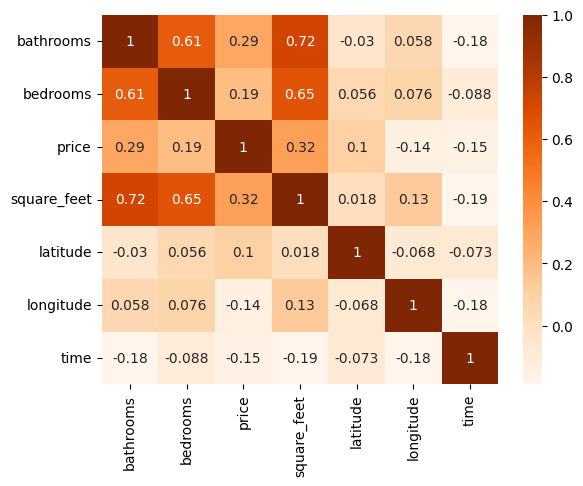

In [22]:
numeric_df = df_2.select_dtypes(include=['number']) 
sns.heatmap(numeric_df.corr(), cmap="Oranges", annot=True)

<Axes: >

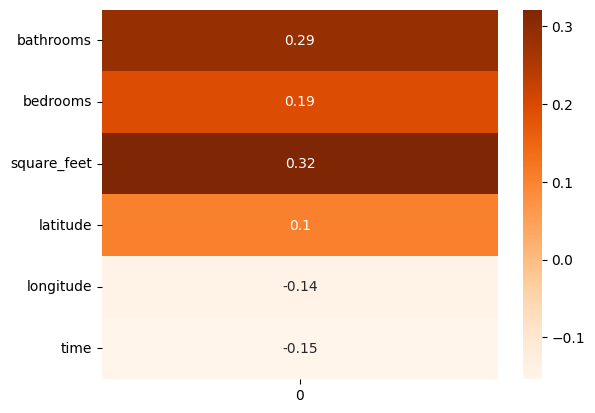

In [23]:
corr_price = numeric_df.drop(['price'], axis=1).corrwith(numeric_df['price'])
sns.heatmap(pd.DataFrame(corr_price), cmap="Oranges", annot=True)

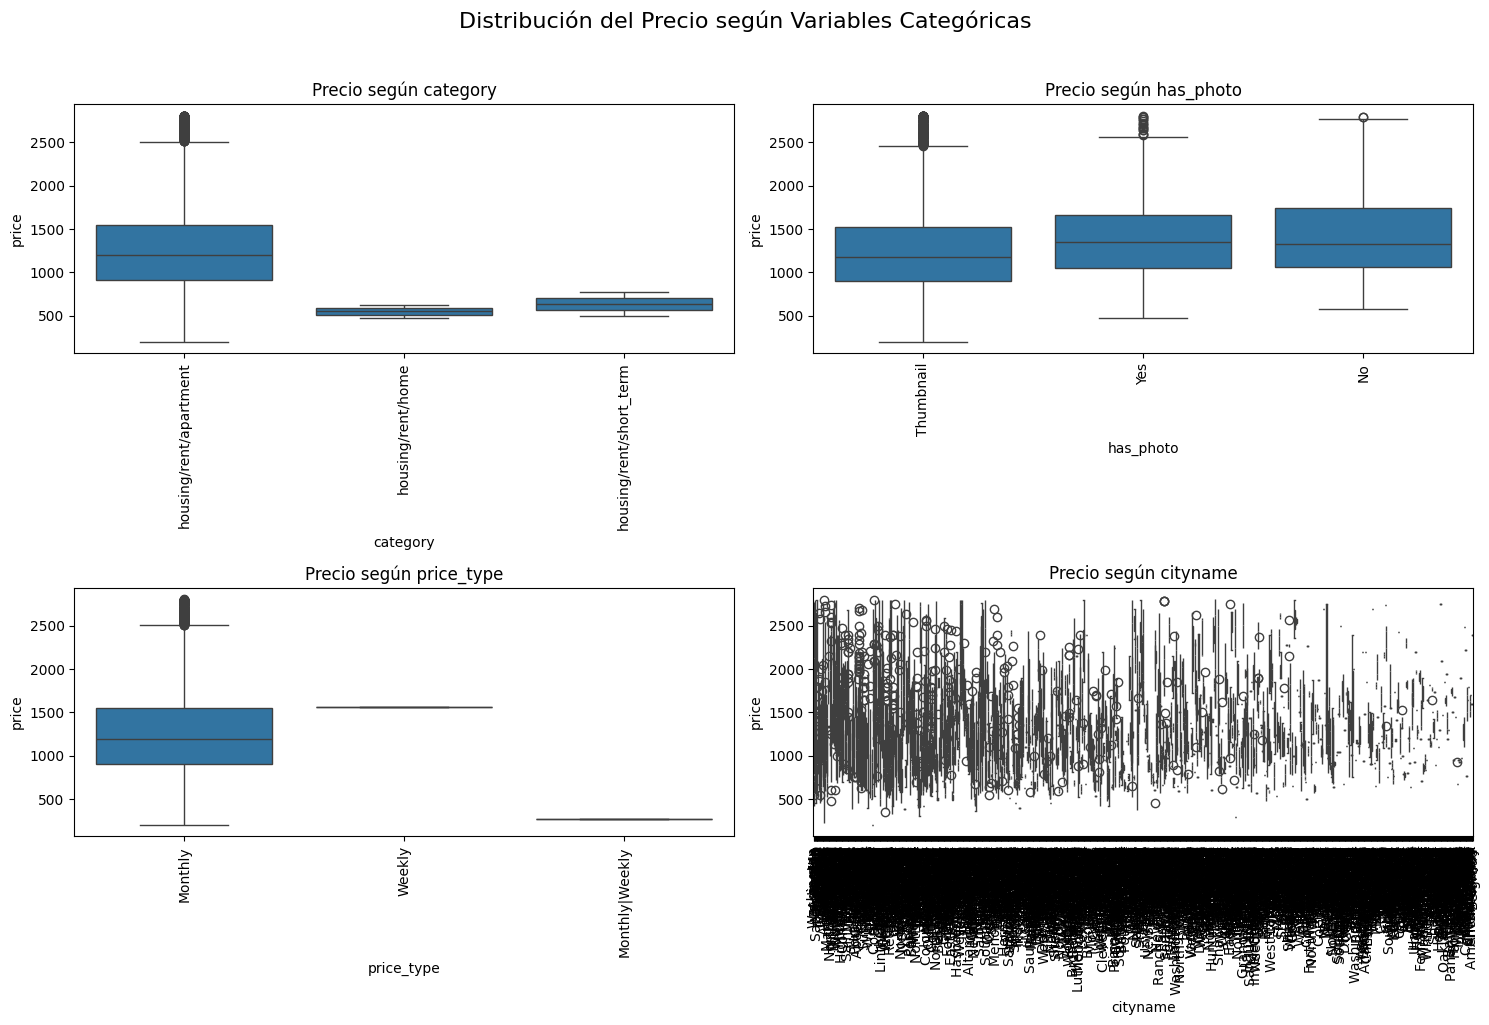

In [24]:
mi_boxplot_grid(df_2, Variables_NoNum, nrows=2, ncols=2)

En esta revisión de la nueva data limpia, se evidencia que cambian un poco las correlaciones de las variables numéricas con el precio y respecto a las categóricas, sin el rigor de una prueba de hipótesis se podría opinar que los factores de la variable _has\_photo_ no parecen ser significativos

## Modelo de regresión

Con la exploración de los datos y la experiencia del anterior modelo se propone el modelo:

$y = \beta_0 + \beta_1 \times \text{bathrooms} + \beta_2 \times \text{bedrooms} + \beta_3 \times \text{square\_feet} + \beta_4 \times \text{category} + \beta_5 \times \text{cityname} + \beta_6 \times \text{price\_type}$ 

In [25]:
Variables_NoNum.remove("has_photo")
Variables_Num.remove("latitude")
Variables_Num.remove("longitude")
Variables_Num.remove("time")

Variables_explicativas = Variables_NoNum + Variables_Num
print(Variables_explicativas)

['category', 'price_type', 'cityname', 'bathrooms', 'bedrooms', 'price', 'square_feet']


In [26]:
df_modelo = df_2[Variables_explicativas]
df_modelo = pd.get_dummies(df_modelo, columns=Variables_NoNum, drop_first=True)
df_modelo.head()


,bathrooms,bedrooms,price,square_feet,category_housing/rent/home,category_housing/rent/short_term,price_type_Monthly|Weekly,price_type_Weekly,cityname_Abilene,cityname_Abingdon,...,cityname_Yakima,cityname_Yonkers,cityname_York,cityname_Yorktown,cityname_Yorkville,cityname_Youngstown,cityname_Youngsville,cityname_Ypsilanti,cityname_Yukon,cityname_Zachary
0,1.0,0.0,790,101,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.0,1.0,425,106,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.0,0.0,1390,107,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.0,0.0,925,116,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.0,0.0,880,125,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [27]:
features = df_modelo.columns.tolist()
features.remove('price')
X = df_modelo[features]
Y = df_modelo['price'] 

### Entrenamiento del modelo

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

print(f"Dimensiones X de entrenamiento {X_train.shape}\nDimensiones X de test {X_test.shape}\nDimensiones Y de entrenamiento {Y_train.shape}\nDimensiones Y de test {Y_test.shape}")

Dimensiones X de entrenamiento (6519, 1429)
Dimensiones X de test (2174, 1429)
Dimensiones Y de entrenamiento (6519,)
Dimensiones Y de test (2174,)


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled, Y_train)

Y_pred = linreg.predict(X_test_scaled)

print(f"Intercepto: {linreg.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(features, linreg.coef_):
    print(f"  {feature}: {coef:.4f}")

Intercepto: 1278.6696
Coeficientes:
  bathrooms: 45.3730
  bedrooms: 6.1192
  square_feet: 186.3417
  category_housing/rent/home: 0.0723
  category_housing/rent/short_term: -10.6277
  price_type_Monthly|Weekly: -3.1346
  price_type_Weekly: 0.0000
  cityname_Abilene: -7.8925
  cityname_Abingdon: -0.6402
  cityname_Abington: 6.2605
  cityname_Absecon: -2.7324
  cityname_Addison: -0.0706
  cityname_Adelphi: 0.0000
  cityname_Agoura Hills: 13.6254
  cityname_Akron: -2.5912
  cityname_Alameda: 17.6060
  cityname_Albany: -0.4667
  cityname_Albuquerque: -4.4510
  cityname_Alexandria: 15.5898
  cityname_Alhambra: 10.7961
  cityname_Aliquippa: -1.1971
  cityname_Allston: 19.2332
  cityname_Aloha: 2.9451
  cityname_Alpharetta: 8.0306
  cityname_Alpine: 4.7023
  cityname_Altamonte Springs: -1.5797
  cityname_Altoona: -4.9382
  cityname_Alvin: -0.6388
  cityname_Amarillo: -10.5494
  cityname_Amelia: -4.3900
  cityname_American Canyon: 6.7708
  cityname_American Fork: -2.7218
  cityname_Ames: -24.6

### Evaluación del modelo

**Error absoluto medio**: 

$$\text{MAE} = \frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Error cuadrado medio**: 
$$\text{MSE} = \frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Raíz del Error cuadrado medio**: 
$$\text{RMSE} = \sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [31]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(Y_test, Y_pred)
MSE = metrics.mean_squared_error(Y_test, Y_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Squared Error (MSE): {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
R2 = metrics.r2_score(Y_test, Y_pred)
print(f"Coeficiente de determinación (R2): {R2:.4f}")

Mean Absolute Error (MAE): 231.7149
Mean Squared Error (MSE): 107319.9818
Root Mean Squared Error (RMSE): 327.5973
Coeficiente de determinación (R2): 0.5542


### Visualización

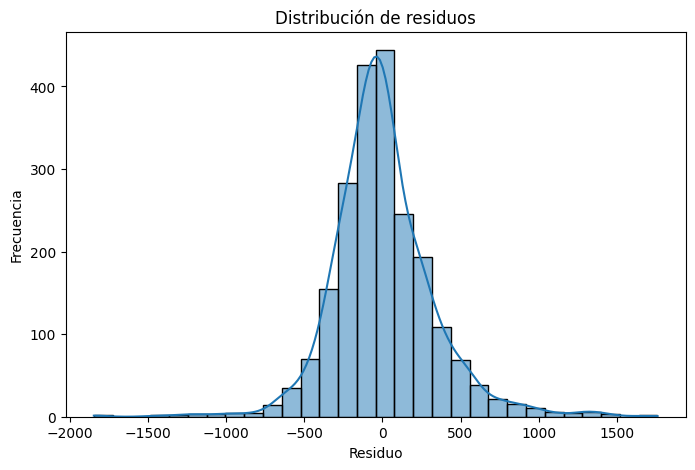

In [32]:
import matplotlib.pyplot as plt

residuals = Y_test - Y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuos")
plt.show()

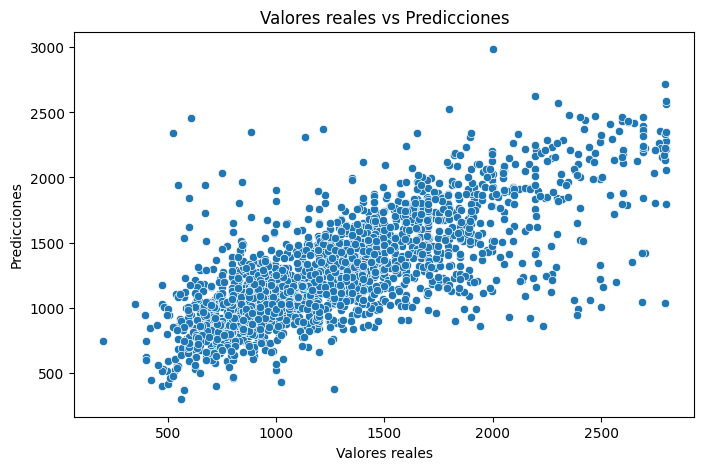

In [33]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=Y_test, y=Y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.show()

# Iteración 3

Random Forest - Métricas iniciales:
Mean Absolute Error (MAE): 270.6659
Mean Squared Error (MSE): 144963.0696
Root Mean Squared Error (RMSE): 380.7402
Coeficiente de determinación (R2): 0.3978


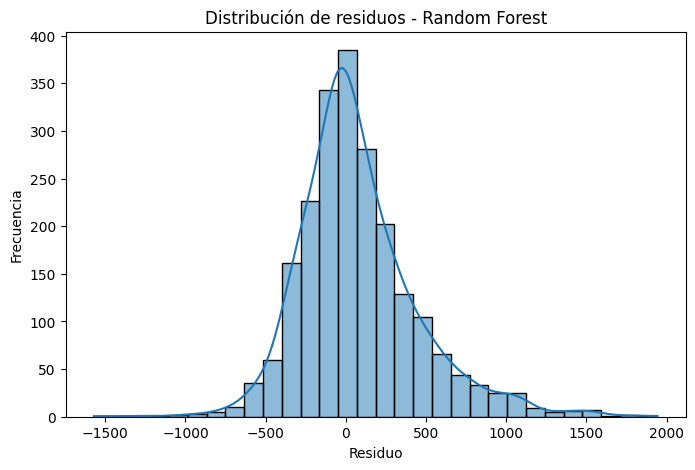

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=1)

rf.fit(X_train_scaled, Y_train)

Y_pred_rf = rf.predict(X_test_scaled)

MAE_rf = metrics.mean_absolute_error(Y_test, Y_pred_rf)
MSE_rf = metrics.mean_squared_error(Y_test, Y_pred_rf)
RMSE_rf = np.sqrt(MSE_rf)
R2_rf = metrics.r2_score(Y_test, Y_pred_rf)

print(f"Random Forest - Métricas iniciales:")
print(f"Mean Absolute Error (MAE): {MAE_rf:.4f}")
print(f"Mean Squared Error (MSE): {MSE_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE_rf:.4f}")
print(f"Coeficiente de determinación (R2): {R2_rf:.4f}")

residuals_rf = Y_test - Y_pred_rf
plt.figure(figsize=(8,5))
sns.histplot(residuals_rf, bins=30, kde=True)
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.title("Distribución de residuos - Random Forest")
plt.show()


In [35]:
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# random_search = RandomizedSearchCV(
#     RandomForestRegressor(random_state=1),
#     param_distributions=param_dist,
#     n_iter=10,  
#     cv=2,  
#     n_jobs=-1,
#     verbose=1,
#     random_state=1
# )

# random_search.fit(X_train_scaled, Y_train)

# best_rf = random_search.best_estimator_

# Y_pred_best_rf = best_rf.predict(X_test_scaled)

# R2_best_rf = metrics.r2_score(Y_test, Y_pred_best_rf)
# print(f"Mejor R2 tras optimización: {R2_best_rf:.4f}")

# Iteración 4

Reconociendo que hay un espacio de mejora por las métricas del modelo. Se intentará usar mejor los features para conseguir un mejor desempeño

Una de las posibles causas que restringieron el desempeño del modelo propuesto anteriormente fue que al generar dummies para todas las ciudades se generaban demasiadas columnas lo que disminuía el provecho descriptivo de los datos

## Agrupaciones y nuevos features

In [36]:
df_2.head()

,category,bathrooms,bedrooms,has_photo,price,price_display,price_type,square_feet,cityname,latitude,longitude,time
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,790,Monthly,101,Washington,389057.0,-769861.0,1577359415
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,425,Monthly,106,Evansville,379680.0,-876621.0,1577017063
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,1.39,Monthly,107,Arlington,388910.0,-770816.0,1577359410
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,925,Monthly,116,Seattle,476160.0,-1223275.0,1576667743
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,880,Monthly,125,Arlington,388738.0,-771055.0,1577359401


In [37]:
df_2['cityname'].value_counts().head(60)

cityname
Austin              519
Dallas              208
Houston             181
San Antonio         175
Chicago             129
Los Angeles         107
Denver              100
Madison              98
Portland             98
Kansas City          98
Arlington            87
Cincinnati           80
Colorado Springs     80
Las Vegas            77
Seattle              76
Omaha                73
Raleigh              70
Ames                 70
Washington           69
Marietta             63
Milwaukee            62
Minneapolis          61
West Lafayette       53
Phoenix              51
Oklahoma City        50
Bloomington          49
Saint Louis          48
Euless               47
Pittsburgh           45
Columbia             44
Sioux Falls          43
Atlanta              43
Champaign            42
Springfield          42
Philadelphia         42
Norman               39
Minot                38
San Diego            37
Renton               37
Kent                 36
Durham               36
Tampa  

In [38]:
top_cities = df_2['cityname'].value_counts().head(60).index
del(df_modelo)
df_modelo = df_2
df_modelo['cityname_grouped'] = df_modelo['cityname'].apply(lambda x: x if x in top_cities else 'others')

df_dummies = pd.get_dummies(df_modelo['cityname_grouped'], prefix='city')

df_modelo = pd.concat([df_modelo, df_dummies], axis=1)
df_modelo.head()

,category,bathrooms,bedrooms,has_photo,price,price_display,price_type,square_feet,cityname,latitude,...,city_San Diego,city_San Francisco,city_Seattle,city_Silver Spring,city_Sioux Falls,city_Springfield,city_Tampa,city_Washington,city_West Lafayette,city_others
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,790,Monthly,101,Washington,389057.0,...,False,False,False,False,False,False,False,True,False,False
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,425,Monthly,106,Evansville,379680.0,...,False,False,False,False,False,False,False,False,False,True
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,1.39,Monthly,107,Arlington,388910.0,...,False,False,False,False,False,False,False,False,False,False
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,925,Monthly,116,Seattle,476160.0,...,False,False,True,False,False,False,False,False,False,False
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,880,Monthly,125,Arlington,388738.0,...,False,False,False,False,False,False,False,False,False,False


In [39]:
df_2['square_feet'].describe()

count    8693.000000
mean      824.098930
std       295.681473
min       101.000000
25%       629.000000
50%       774.000000
75%      1000.000000
max      1776.000000
Name: square_feet, dtype: float64

In [40]:
bins = [0, 649, 1100, float('inf')]  
labels = ['small', 'medium', 'big']

df_modelo['size_category'] = pd.cut(df_modelo['square_feet'], bins=bins, labels=labels, right=True)
df_modelo.head()

,category,bathrooms,bedrooms,has_photo,price,price_display,price_type,square_feet,cityname,latitude,...,city_San Francisco,city_Seattle,city_Silver Spring,city_Sioux Falls,city_Springfield,city_Tampa,city_Washington,city_West Lafayette,city_others,size_category
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,790,Monthly,101,Washington,389057.0,...,False,False,False,False,False,False,True,False,False,small
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,425,Monthly,106,Evansville,379680.0,...,False,False,False,False,False,False,False,False,True,small
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,1.39,Monthly,107,Arlington,388910.0,...,False,False,False,False,False,False,False,False,False,small
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,925,Monthly,116,Seattle,476160.0,...,False,True,False,False,False,False,False,False,False,small
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,880,Monthly,125,Arlington,388738.0,...,False,False,False,False,False,False,False,False,False,small


In [41]:
df_modelo = pd.get_dummies(df_modelo, columns=['size_category'], prefix='size')
df_modelo = pd.get_dummies(df_modelo, columns=['category'])

In [42]:
df_modelo.columns

Index(['bathrooms', 'bedrooms', 'has_photo', 'price', 'price_display',
       'price_type', 'square_feet', 'cityname', 'latitude', 'longitude',
       'time', 'cityname_grouped', 'city_Ames', 'city_Arlington',
       'city_Atlanta', 'city_Austin', 'city_Baltimore', 'city_Bellevue',
       'city_Bloomington', 'city_Champaign', 'city_Charlotte', 'city_Chicago',
       'city_Cincinnati', 'city_Colorado Springs', 'city_Columbia',
       'city_Columbus', 'city_Dallas', 'city_Denver', 'city_Durham',
       'city_Edmond', 'city_Euless', 'city_Greensboro', 'city_Houston',
       'city_Kansas City', 'city_Kent', 'city_Kirkland', 'city_Lafayette',
       'city_Las Vegas', 'city_Lawrenceville', 'city_Long Beach',
       'city_Los Angeles', 'city_Lynnwood', 'city_Madison', 'city_Manchester',
       'city_Marietta', 'city_Milwaukee', 'city_Minneapolis', 'city_Minot',
       'city_Norman', 'city_Oklahoma City', 'city_Omaha', 'city_Orlando',
       'city_Pasadena', 'city_Philadelphia', 'city_Phoenix'

## Modelo de regresión

Este modelo considerará las agrupaciones realizadas que consiguen reducir la cantidad de columnas, entonces resulta:

$y = \beta_0 + \beta_1 \times \text{bathrooms} + \beta_2 \times \text{bedrooms} + \beta_3 \times \text{size} + \beta_4 \times \text{TopCities} + \beta_5 \times \text{category} + \beta_6 \times \text{price\_type}$

_Topcities_ responde a la agrupación donde cualquier observación que no pertenezca a las ciudades más frecuentes de los datos clasifica como 'others'

_Size_ responde a la agrupación de observaciones entre small, medium y big y según los cuartiles 

In [43]:
features = ['bathrooms', 'bedrooms', 'price', 'city_Austin', 'city_Chicago',
       'city_Dallas', 'city_Denver', 'city_Houston', 'city_Kansas City',
       'city_Los Angeles', 'city_Madison', 'city_Portland', 'city_San Antonio',
       'city_others', 'size_small', 'size_medium', 'size_big', 'category_housing/rent/apartment', 'category_housing/rent/home',
       'category_housing/rent/short_term']

features.remove('price')

X = df_modelo[features]
Y = df_modelo['price'] 

### Entrenamiento del modelo

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

print(f"Dimensiones X de entrenamiento {X_train.shape}\nDimensiones X de test {X_test.shape}\nDimensiones Y de entrenamiento {Y_train.shape}\nDimensiones Y de test {Y_test.shape}")

Dimensiones X de entrenamiento (6519, 19)
Dimensiones X de test (2174, 19)
Dimensiones Y de entrenamiento (6519,)
Dimensiones Y de test (2174,)


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [46]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled, Y_train)

Y_pred = linreg.predict(X_test_scaled)

print(f"Intercepto: {linreg.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(features, linreg.coef_):
    print(f"  {feature}: {coef:.4f}")

Intercepto: 1278.6696
Coeficientes:
  bathrooms: 85.7672
  bedrooms: -7.7965
  city_Austin: 5.4075
  city_Chicago: 34.1347
  city_Dallas: -1.4954
  city_Denver: 18.2649
  city_Houston: -33.3553
  city_Kansas City: -26.5533
  city_Los Angeles: 100.1533
  city_Madison: 7.4157
  city_Portland: 20.6732
  city_San Antonio: -28.2480
  city_others: -2.8505
  size_small: -62.6411
  size_medium: 8.8437
  size_big: 62.5656
  category_housing/rent/apartment: 7.0696
  category_housing/rent/home: -3.4177
  category_housing/rent/short_term: -6.2409


### Evaluación del modelo

**Error absoluto medio**: 

$$\text{MAE} = \frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Error cuadrado medio**: 
$$\text{MSE} = \frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Raíz del Error cuadrado medio**: 
$$\text{RMSE} = \sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [47]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(Y_test, Y_pred)
MSE = metrics.mean_squared_error(Y_test, Y_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Squared Error (MSE): {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
R2 = metrics.r2_score(Y_test, Y_pred)
print(f"Coeficiente de determinación (R2): {R2:.4f}")

Mean Absolute Error (MAE): 347.3950
Mean Squared Error (MSE): 198252.2391
Root Mean Squared Error (RMSE): 445.2553
Coeficiente de determinación (R2): 0.1765


## Modelo alternativo

In [48]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)

R2_rf = metrics.r2_score(Y_test, Y_pred_rf)
print(f"Random Forest R2: {R2_rf:.4f}")

Random Forest R2: 0.1787


# Iteración 5

Ante el desempeño de los modelos anteriores y un nuevo avance de Ingeniería y análisis de datos. La iteración 5 se hará con el nuevo data set por lo que se inicia desde la exploración

In [49]:
df_3 = pd.read_csv("data_limpia_3.csv")
df_3.head()

,category,bathrooms,bedrooms,has_photo,price,price_type,square_feet,state,latitude,longitude,time
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,Monthly,101,Otros,389057.0,-769861.0,1577359415
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,Monthly,106,IN,379680.0,-876621.0,1577017063
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,Monthly,107,VA,388910.0,-770816.0,1577359410
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,Monthly,116,WA,476160.0,-1223275.0,1576667743
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,Monthly,125,VA,388738.0,-771055.0,1577359401


In [50]:
Variables_Num = df_3.select_dtypes(include=['number']).columns.tolist()
Variables_NoNum = df_3.select_dtypes(exclude=['number']).columns.tolist()
df_3.columns

Index(['category', 'bathrooms', 'bedrooms', 'has_photo', 'price', 'price_type',
       'square_feet', 'state', 'latitude', 'longitude', 'time'],
      dtype='object')

## Exploración y visualización de datos

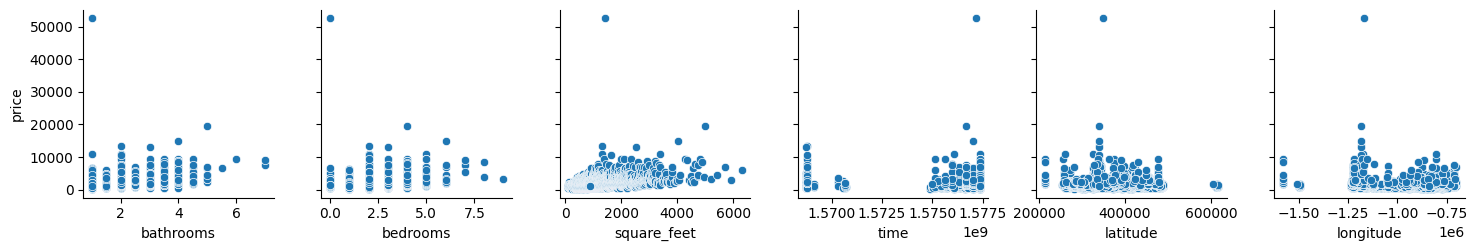

In [51]:
sns.pairplot(df_3, x_vars=['bathrooms', 'bedrooms', 'square_feet', 'time', 'latitude', 'longitude'], y_vars=['price'])
plt.show()

<Axes: >

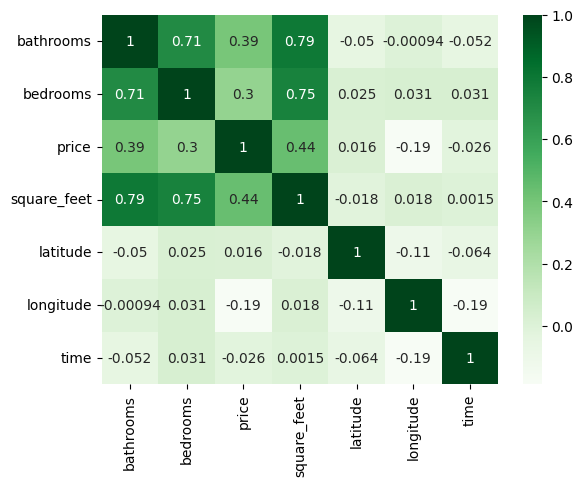

In [52]:
numeric_df = df_3.select_dtypes(include=['number']) 
sns.heatmap(numeric_df.corr(), cmap="Greens", annot=True)

<Axes: >

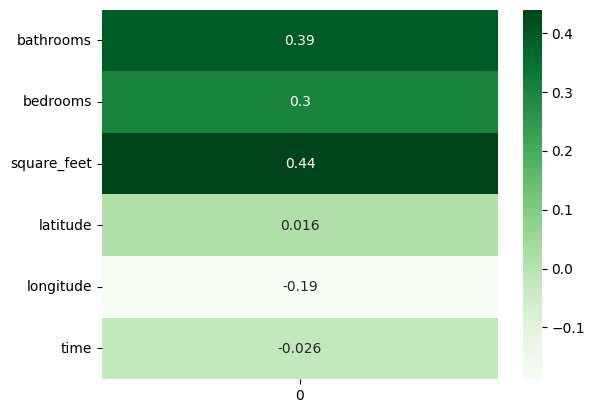

In [53]:
corr_price = numeric_df.drop(['price'], axis=1).corrwith(numeric_df['price'])
sns.heatmap(pd.DataFrame(corr_price), cmap="Greens", annot=True)

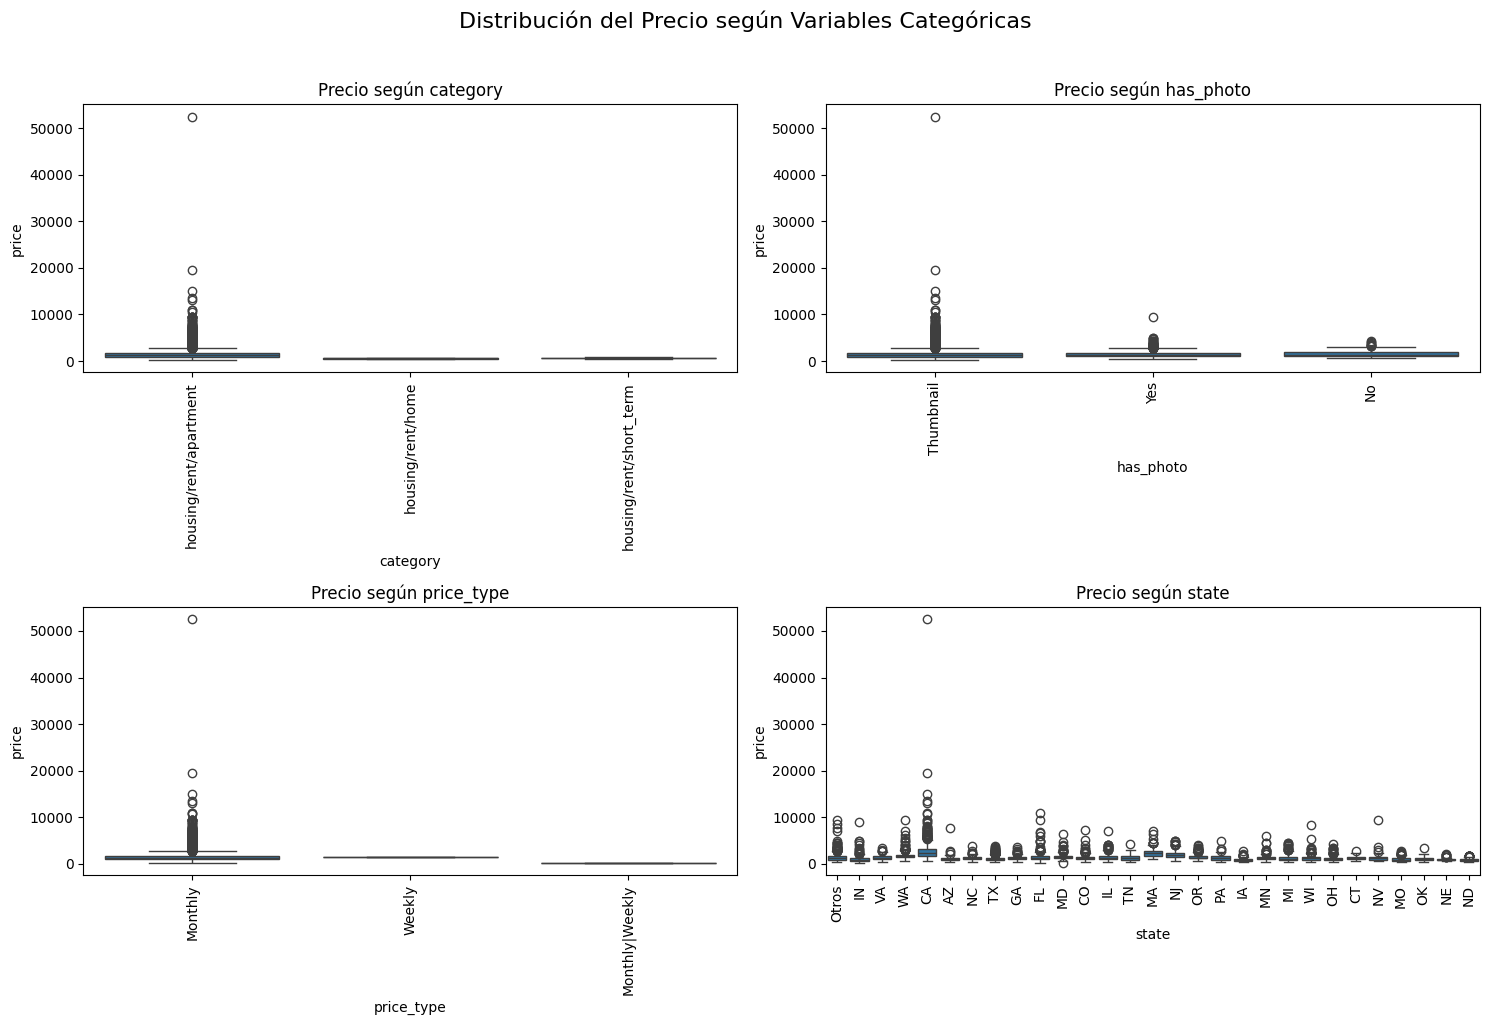

In [54]:
mi_boxplot_grid(df_3, Variables_NoNum, nrows=2, ncols=2)

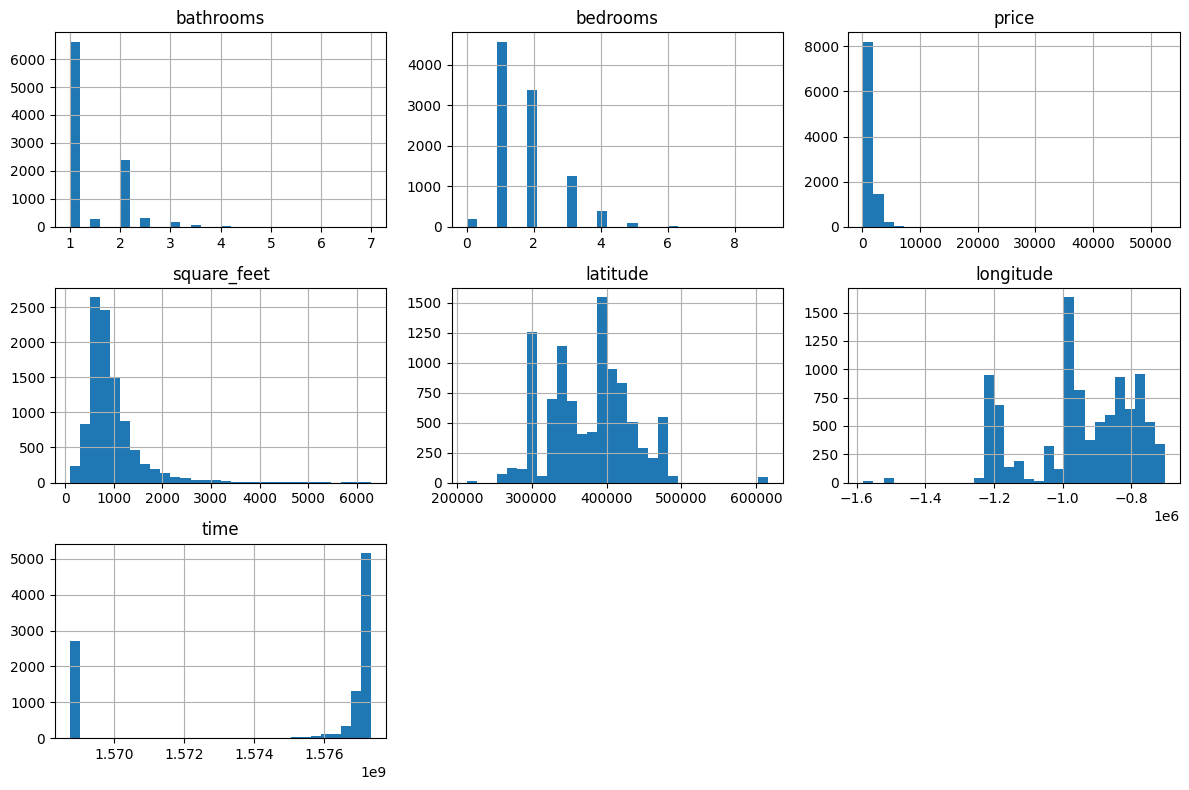

In [55]:
df_3[Variables_Num].hist(bins=30, figsize=(12, 8), layout=(3, 3))  
plt.tight_layout()
plt.show()

## Elección de variables

Para aumentar el rigor del modelamiento e intentar obtener un modelo con buen desempeño se decidió tener indicios más robustos mediante pruebas estadísticas

In [73]:
from scipy.stats import pearsonr
from scipy.stats import f_oneway

for var in Variables_Num:
    if var != 'price':
        corr, p_value = pearsonr(df_3[var], df_3['price'])
        print(f"Correlación entre {var} y precio: {corr:.4f}, Pvalue: {p_value:.4f}")

for var in Variables_NoNum:
    groups = [df_3[df_3[var] == category]['price'] for category in df_3[var].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA para {var}: F = {f_stat:.4f}, Pvalue = {p_value:.4f}")

Correlación entre bathrooms y precio: 0.3939, Pvalue: 0.0000
Correlación entre bedrooms y precio: 0.3014, Pvalue: 0.0000
Correlación entre square_feet y precio: 0.4391, Pvalue: 0.0000
Correlación entre latitude y precio: 0.0160, Pvalue: 0.1111
Correlación entre longitude y precio: -0.1879, Pvalue: 0.0000
Correlación entre time y precio: -0.0255, Pvalue: 0.0111
ANOVA para category: F = 1.4436, Pvalue = 0.2361
ANOVA para has_photo: F = 1.0736, Pvalue = 0.3418
ANOVA para price_type: F = 0.6670, Pvalue = 0.5132
ANOVA para state: F = 106.6941, Pvalue = 0.0000


Este análisis estadístico sugiere que se deberían tener en cuenta: _bathrooms_, _bedrooms_, _square\_feet_, _longitude_ y _state_. 
Pero, se sabe que _longitude_ aporta una información que probablemente pueda explicar también _state_

## Modelo de regresión - A

El modelo por las pruebas y visualizaciones anteriores será:

$y = \beta_0 + \beta_1 \times \text{bathrooms} + \beta_2 \times \text{bedrooms} + \beta_3 \times \text{square\_ feet} + \beta_4 \times \text{state} $

In [57]:
df_modelo = df_3
df_modelo = pd.get_dummies(df_modelo, columns=['state'])
df_modelo.columns

Index(['category', 'bathrooms', 'bedrooms', 'has_photo', 'price', 'price_type',
       'square_feet', 'latitude', 'longitude', 'time', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_FL', 'state_GA', 'state_IA', 'state_IL',
       'state_IN', 'state_MA', 'state_MD', 'state_MI', 'state_MN', 'state_MO',
       'state_NC', 'state_ND', 'state_NE', 'state_NJ', 'state_NV', 'state_OH',
       'state_OK', 'state_OR', 'state_Otros', 'state_PA', 'state_TN',
       'state_TX', 'state_VA', 'state_WA', 'state_WI'],
      dtype='object')

In [58]:
features = ['bathrooms', 'bedrooms', 'square_feet', 'time', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_FL', 'state_GA', 'state_IA', 'state_IL',
       'state_IN', 'state_MA', 'state_MD', 'state_MI', 'state_MN', 'state_MO',
       'state_NC', 'state_ND', 'state_NE', 'state_NJ', 'state_NV', 'state_OH',
       'state_OK', 'state_OR', 'state_Otros', 'state_PA', 'state_TN',
       'state_TX', 'state_VA', 'state_WA', 'state_WI']
df_modelo = df_modelo[features]
X = df_modelo[features]
Y = df_3['price'] 

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

print(f"Dimensiones X de entrenamiento {X_train.shape}\nDimensiones X de test {X_test.shape}\nDimensiones Y de entrenamiento {Y_train.shape}\nDimensiones Y de test {Y_test.shape}")

Dimensiones X de entrenamiento (7435, 33)
Dimensiones X de test (2479, 33)
Dimensiones Y de entrenamiento (7435,)
Dimensiones Y de test (2479,)


In [60]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, Y_train)

Y_pred = linreg.predict(X_test)

print(f"Intercepto: {linreg.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(features, linreg.coef_):
    print(f"  {feature}: {coef:.4f}")

Intercepto: -7664.8567
Coeficientes:
  bathrooms: 205.2757
  bedrooms: -72.9084
  square_feet: 0.8399
  time: 0.0000
  state_AZ: -189.8135
  state_CA: 1365.5058
  state_CO: 92.9644
  state_CT: 42.8967
  state_FL: 25.6576
  state_GA: -294.7075
  state_IA: -414.4655
  state_IL: 188.0543
  state_IN: -289.7018
  state_MA: 1020.4646
  state_MD: 198.9735
  state_MI: -101.0862
  state_MN: 101.6442
  state_MO: -333.2226
  state_NC: -378.2727
  state_ND: -532.7862
  state_NE: -376.4853
  state_NJ: 647.8568
  state_NV: -222.2251
  state_OH: -306.6216
  state_OK: -424.3765
  state_OR: 119.3221
  state_Otros: -116.7189
  state_PA: 2.8733
  state_TN: -132.3882
  state_TX: -121.4514
  state_VA: 73.1827
  state_WA: 414.9345
  state_WI: -60.0076


### Evaluación del modelo

In [61]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(Y_test, Y_pred)
MSE = metrics.mean_squared_error(Y_test, Y_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Squared Error (MSE): {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
R2 = metrics.r2_score(Y_test, Y_pred)
print(f"Coeficiente de determinación (R2): {R2:.4f}")

Mean Absolute Error (MAE): 368.1374
Mean Squared Error (MSE): 348880.2716
Root Mean Squared Error (RMSE): 590.6609
Coeficiente de determinación (R2): 0.5474


## Modelo de regresión - B

Considerando que _State_ puede estar aportando información similar a la que se consigue en conjunto con _latitud_ y _longitude_. Esta segunda opción considera que los Dummies de state podrían estar aportando poca información útil o incluso ruido.

In [62]:
df_modelo = df_3
df_modelo.columns

Index(['category', 'bathrooms', 'bedrooms', 'has_photo', 'price', 'price_type',
       'square_feet', 'state', 'latitude', 'longitude', 'time'],
      dtype='object')

In [63]:
features = ['bathrooms', 'bedrooms','square_feet', 'latitude', 'longitude']

df_modelo = df_modelo[features]
X = df_modelo[features]
Y = df_3['price']

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

print(f"Dimensiones X de entrenamiento {X_train.shape}\nDimensiones X de test {X_test.shape}\nDimensiones Y de entrenamiento {Y_train.shape}\nDimensiones Y de test {Y_test.shape}")

Dimensiones X de entrenamiento (7435, 5)
Dimensiones X de test (2479, 5)
Dimensiones Y de entrenamiento (7435,)
Dimensiones Y de test (2479,)


In [65]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, Y_train)

Y_pred = linreg.predict(X_test)

print(f"Intercepto: {linreg.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(features, linreg.coef_):
    print(f"  {feature}: {coef:.4f}")

Intercepto: -702.7824
Coeficientes:
  bathrooms: 246.7165
  bedrooms: -122.1065
  square_feet: 0.8655
  latitude: 0.0002
  longitude: -0.0012


### Evaluación del modelo

In [66]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(Y_test, Y_pred)
MSE = metrics.mean_squared_error(Y_test, Y_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Squared Error (MSE): {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
R2 = metrics.r2_score(Y_test, Y_pred)
print(f"Coeficiente de determinación (R2): {R2:.4f}")

Mean Absolute Error (MAE): 488.8059
Mean Squared Error (MSE): 545345.4790
Root Mean Squared Error (RMSE): 738.4751
Coeficiente de determinación (R2): 0.2925


## Modelo de regresión - C

Como último intento por mejorar el modelo, se hará un poco de ingeniería de features agregando una columna de densidad de habitaciones por pie cuadrado y una transformación logarítmica en precio (para reducir el impacto de outliers).

In [67]:
df_modelo = df_3

df_modelo["log_price"] = np.log1p(df_modelo["price"])
df_modelo["room_density"] = (df_modelo["bedrooms"] + df_modelo["bathrooms"]) / (df_modelo["square_feet"])
df_modelo = pd.get_dummies(df_modelo, columns=['state'])

df_modelo.columns

Index(['category', 'bathrooms', 'bedrooms', 'has_photo', 'price', 'price_type',
       'square_feet', 'latitude', 'longitude', 'time', 'log_price',
       'room_density', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_FL', 'state_GA', 'state_IA', 'state_IL', 'state_IN', 'state_MA',
       'state_MD', 'state_MI', 'state_MN', 'state_MO', 'state_NC', 'state_ND',
       'state_NE', 'state_NJ', 'state_NV', 'state_OH', 'state_OK', 'state_OR',
       'state_Otros', 'state_PA', 'state_TN', 'state_TX', 'state_VA',
       'state_WA', 'state_WI'],
      dtype='object')

In [68]:
df_modelo.head()

,category,bathrooms,bedrooms,has_photo,price,price_type,square_feet,latitude,longitude,time,...,state_OH,state_OK,state_OR,state_Otros,state_PA,state_TN,state_TX,state_VA,state_WA,state_WI
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,Monthly,101,389057.0,-769861.0,1577359415,...,False,False,False,True,False,False,False,False,False,False
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,Monthly,106,379680.0,-876621.0,1577017063,...,False,False,False,False,False,False,False,False,False,False
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,Monthly,107,388910.0,-770816.0,1577359410,...,False,False,False,False,False,False,False,True,False,False
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,Monthly,116,476160.0,-1223275.0,1576667743,...,False,False,False,False,False,False,False,False,True,False
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,Monthly,125,388738.0,-771055.0,1577359401,...,False,False,False,False,False,False,False,True,False,False


In [69]:


features = ['bathrooms', 'bedrooms', 'square_feet','room_density', 'state_AZ', 'state_CA', 'state_CO',
       'state_CT', 'state_FL', 'state_GA', 'state_IA', 'state_IL', 'state_IN',
       'state_MA', 'state_MD', 'state_MI', 'state_MN', 'state_MO', 'state_NC',
       'state_ND', 'state_NE', 'state_NJ', 'state_NV', 'state_OH', 'state_OK',
       'state_OR', 'state_Otros', 'state_PA', 'state_TN', 'state_TX',
       'state_VA', 'state_WA', 'state_WI']

#df_modelo = df_modelo[features]
X = df_modelo[features]
Y = df_modelo['log_price']

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

print(f"Dimensiones X de entrenamiento {X_train.shape}\nDimensiones X de test {X_test.shape}\nDimensiones Y de entrenamiento {Y_train.shape}\nDimensiones Y de test {Y_test.shape}")

# print(X_train.isna().sum())  
# print(np.isinf(X_train).sum())  


Dimensiones X de entrenamiento (7435, 33)
Dimensiones X de test (2479, 33)
Dimensiones Y de entrenamiento (7435,)
Dimensiones Y de test (2479,)


In [71]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, Y_train)

Y_pred = linreg.predict(X_test)

print(f"Intercepto: {linreg.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(features, linreg.coef_):
    print(f"  {feature}: {coef:.4f}")

Intercepto: 6.7940
Coeficientes:
  bathrooms: 0.1475
  bedrooms: 0.0678
  square_feet: 0.0002
  room_density: -46.5811
  state_AZ: -0.1077
  state_CA: 0.6688
  state_CO: 0.0976
  state_CT: 0.0627
  state_FL: 0.0445
  state_GA: -0.1134
  state_IA: -0.3262
  state_IL: 0.1108
  state_IN: -0.2453
  state_MA: 0.5855
  state_MD: 0.1892
  state_MI: -0.1177
  state_MN: 0.1125
  state_MO: -0.2788
  state_NC: -0.1805
  state_ND: -0.4019
  state_NE: -0.2613
  state_NJ: 0.4118
  state_NV: -0.1212
  state_OH: -0.2319
  state_OK: -0.2715
  state_OR: 0.1626
  state_Otros: -0.0721
  state_PA: 0.0061
  state_TN: -0.0478
  state_TX: -0.0616
  state_VA: 0.1113
  state_WA: 0.3044
  state_WI: -0.0286


### Evaluación del modelo

In [72]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(Y_test, Y_pred)
MSE = metrics.mean_squared_error(Y_test, Y_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Squared Error (MSE): {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
R2 = metrics.r2_score(Y_test, Y_pred)
print(f"Coeficiente de determinación (R2): {R2:.4f}")

Mean Absolute Error (MAE): 0.2235
Mean Squared Error (MSE): 0.0871
Root Mean Squared Error (RMSE): 0.2952
Coeficiente de determinación (R2): 0.5871


Este modelo de momento es el mejor!